# Run HBV model with ERA5 forcing and GRDC observation

In this notebook you will run your own HBV model using ERA5 forcing data (from the previous notebook) and GRDC observation data. You will have to change a few settings below. Read carefully and decide which inputs and lines to change


In [1]:
#load all dependencies, including your own model through ewatercycle_wrapper_HBV
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print

from ewatercycle_wrapper_HBV import HBV
 


/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


In [2]:
#shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"
shapeFile = forcing_path / "Rhine.shp"

#location to saved forcing results from previous notebook
forcingLocation = forcing_path / "RhineForcing2000-2002"

#GRDC station ID for the observation station
grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

#period of interest. Make sure that GRDC data is available for this period and that.
experiment_start_time="2000-01-01T00:00:00Z"
experiment_end_time="2002-12-31T00:00:00Z"


Forcing was created in the previous notebook and loaded here.

In [3]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-01-01T00:00:00Z',
    end_time='2002-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/teaching-materials/teaching-files/Forcing/RhineForcing2000-2002'),
    shape=PosixPath('/home/rhut/repos/teaching-materials/teaching-files/Forcing/RhineForcing2000-2002/Rhine.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2002.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2002.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2002.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

Now we have the forcing data available we can prepare the configuration files just as in the first notebook. Note that we are using the same parameters as in the first notebook which will not be adequete for our new area (but might be pretty ok, let's see!):

In [4]:
s_0 = np.array([0,  100,  0,  5])
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
par_0 = (p_min_initial + p_max_initial)/2

In [5]:
model = HBV(forcing=ERA5_forcing)

In [7]:
config_file, _ = model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                               )

In [8]:
model.initialize(config_file)

/home/rhut/repos/teaching-materials/teaching-files/hbv_bmi.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.


In [9]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    discharge_this_timestep = model.get_value("Q")
    Q_m.append(discharge_this_timestep[0])
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [10]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

We can plot the output discharge directly using the DataFrame.

Text(0.5, 0, 'Time')

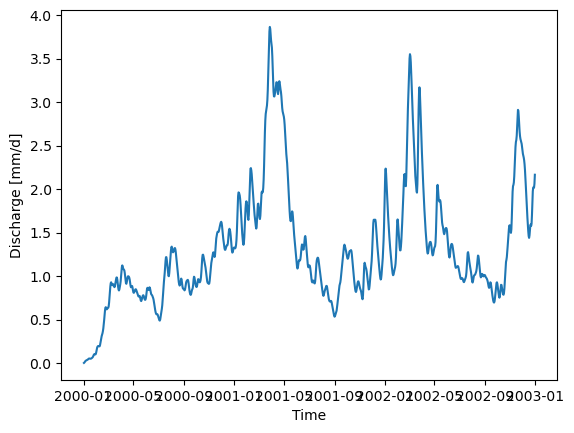

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

df.plot(ax=ax,label="Modeled discharge HBV-bmi")
plt.ylabel(f"Discharge [{model.bmi.get_var_units('Q')}]")
plt.xlabel("Time")

## Analyse results
We can also use the ```hydrograph``` function from eWaterCycle. This will make a hydrograph that compares model output to observations. For this we need to load observations and make sure that the observations and model output are in the same units. Observations typically are in m$^3$/s. 

Note that the unit of discharge from this model is in mm/d. Conversion to m$^3$/s requires the area of the catchment.

In [12]:
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", shape_area)

The catchment area is: 163122500000.0

The hydrograph function requires DataFrames, so we use the DataFrame ```df``` and transform it to m$^3$ per second.

In [14]:
df['model output'] = df['model output'] * shape_area / (1000 * 86400)

The observation data is loaded using ```the get_grdc_data()``` function build into eWaterCycle. The observation data and discharge data are combined together into one DataFrame. Note that we re-index the discharge data to make sure they are at the same timestamp.

In [15]:
observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=experiment_start_time,
    end_time=experiment_end_time,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

In [16]:
hydro_data = pd.concat([discharge_dataframe.reindex(grdc_obs.index, method = 'ffill'), grdc_obs], axis=1)
hydro_data

,model output,Observations from GRDC
time,,
2000-01-01,NaN,6010.0
2000-01-02,2.667401,5330.0
2000-01-03,10.675073,4700.0
2000-01-04,24.033886,4260.0
2000-01-05,38.016808,3980.0
...,...,...
2002-12-27,3813.967532,4560.0
2002-12-28,3808.252888,4420.0
2002-12-29,3809.663991,4350.0


Finally plot the hydrograph. It is remarkabe to see how well a simple model like HBV, without calibration, is already able to predict discharge in the Rhine. Is it also good for your own area? 

/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [0] contained NaN values and the row(s) have been removed (Rows are zero indexed).


(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

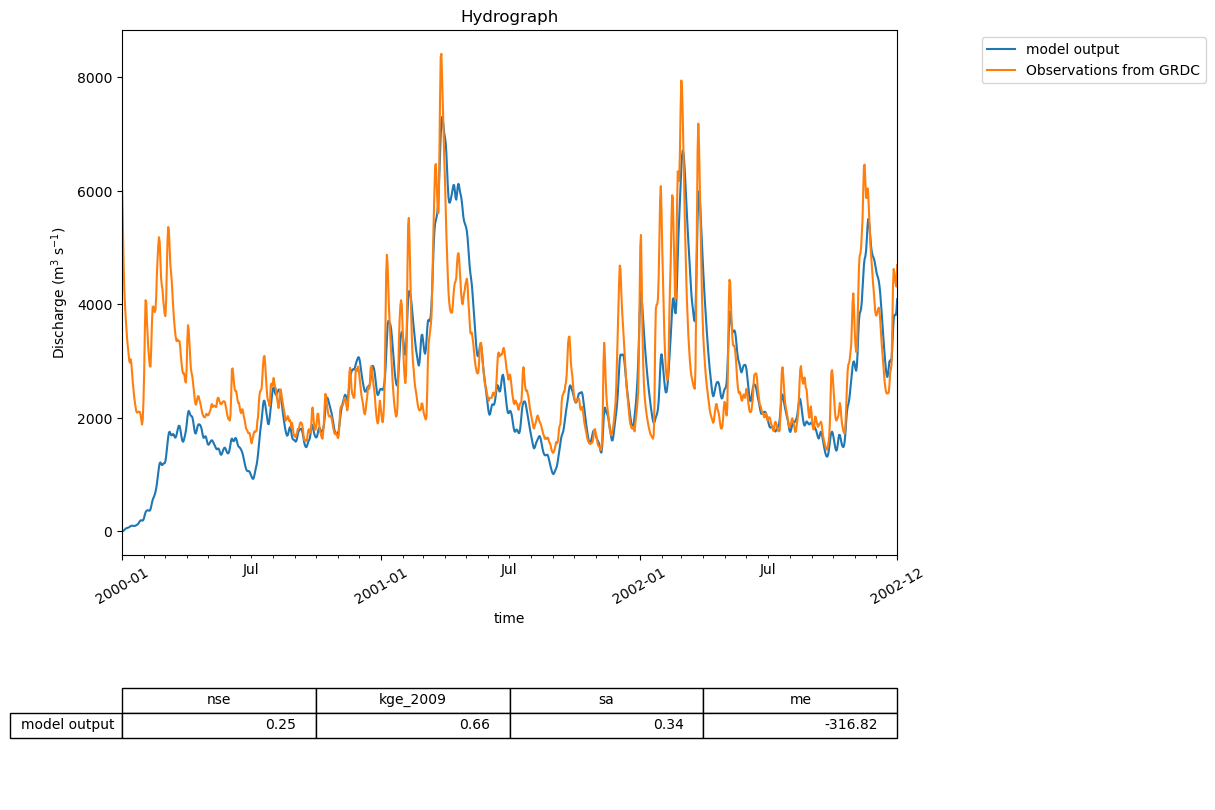

In [18]:
# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='Observations from GRDC', filename = 'experiment_hydrograph.png')

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [19]:
model.finalize()